# LSTM-Based Stock Price Prediction with TensorFlow & Keras
_Predicting future stock prices using historical Microsoft data and deep learning._

In [1]:
# Importing all necessary libraries for data processing, visualization, modeling, and evaluation
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import time 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'# Suppress TensorFlow warnings

In [2]:
# Load and inspect the Microsoft stock dataset
data = pd.read_csv("microsoft_stock.csv")
print(data.head())
print(data.info())
print(data.describe())

    index        date   open   high    low  close    volume  Name
0  390198  2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT
1  390199  2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT
2  390200  2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT
3  390201  2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT
4  390202  2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB
None
               index         open         high          low 

Text(0.5, 1.0, 'Stock Volume over Time')

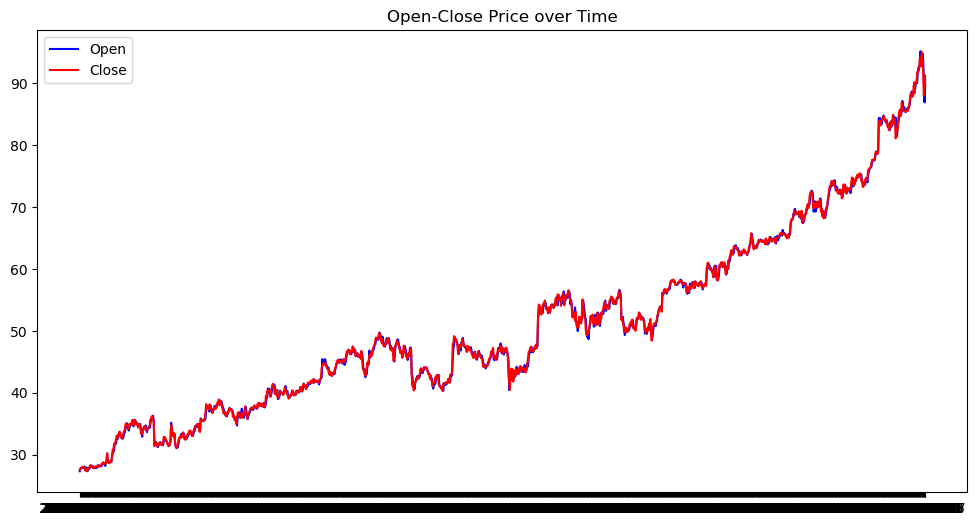

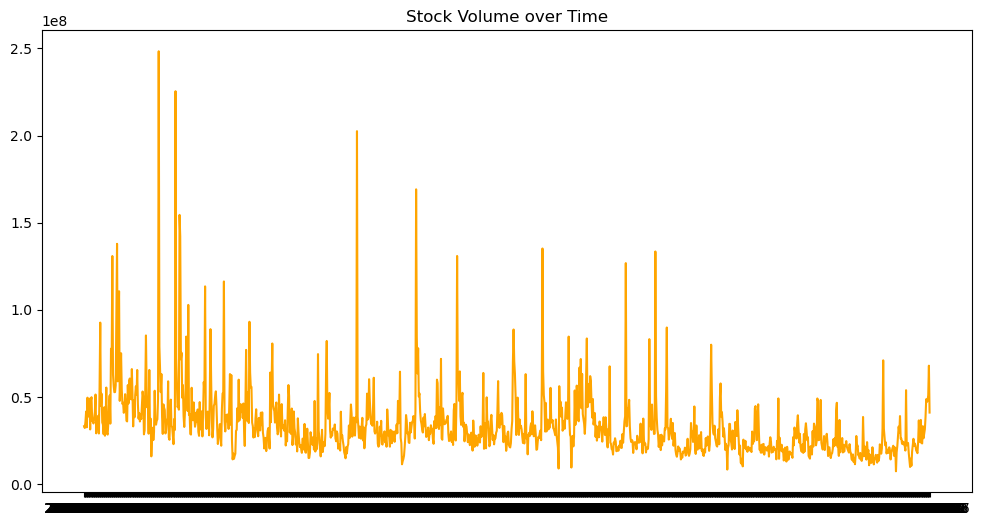

In [3]:
# Visualize key stock trends: Open vs Close prices and Trading Volume over time
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['open'], label="Open",color="blue")
plt.plot(data['date'], data['close'], label="Close",color="red")
plt.title("Open-Close Price over Time")
plt.legend()

plt.figure(figsize=(12,6))
plt.plot(data['date'],data['volume'],label="Volume",color="orange")
plt.title("Stock Volume over Time")

Text(0.5, 1.0, 'Feature Correlation Heatmap')

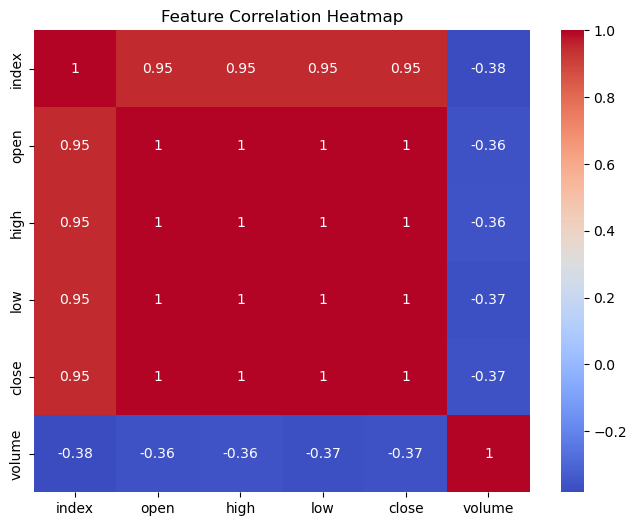

In [4]:
# Explore relationships between numeric features using a correlation heatmap
numeric_data = data.select_dtypes(include=["int64","float64"])

plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")

Text(0.5, 1.0, 'Price over Time')

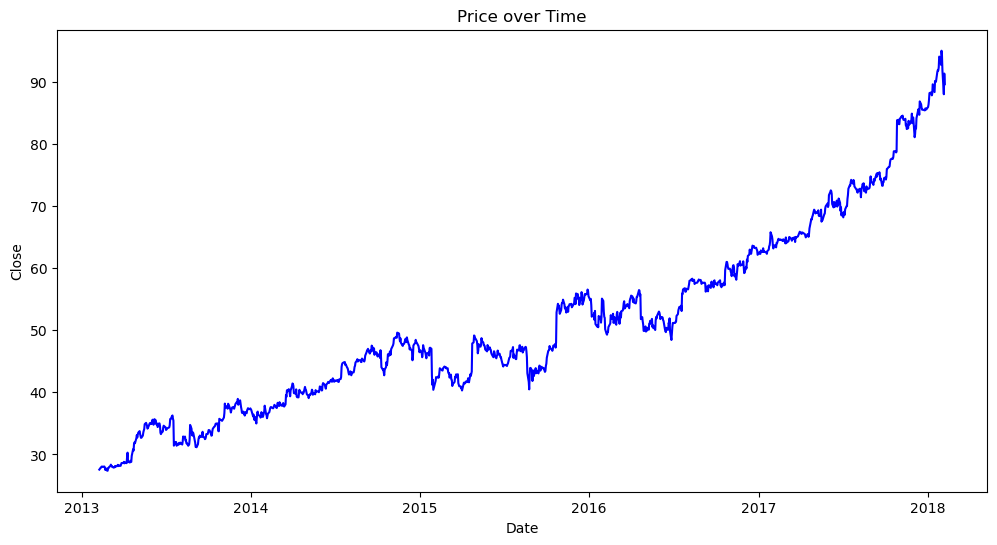

In [5]:
# Convert 'date' column to datetime format and visualize close prices from 2013 to 2018
data['date'] = pd.to_datetime(data['date'])

prediction = data.loc[
    (data['date'] > datetime(2013,1,1)) &
    (data['date'] < datetime(2018,1,1))
]

plt.figure(figsize=(12,6))
plt.plot(data['date'], data['close'], color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over Time")

In [6]:
# Prepare Training Data (Scaling + Sliding Window)
stock_close = data.filter(["close"])
dataset = stock_close.values
training_data_len = int(np.ceil(len(dataset) * 0.95))

# Scale the closing prices
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

# Generate training sequences using past 60 days
training_data = scaled_data[:training_data_len]
X_train, y_train = [], []

for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

# Reshape for LSTM input
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
# Build and train LSTM Model
model = keras.models.Sequential()
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))

model.summary()

model.compile(optimizer="adam",
              loss="mae",
              metrics=[keras.metrics.RootMeanSquaredError()])

training = model.fit(X_train, y_train, epochs=20, batch_size=32)

/opt/anaconda3/envs/lstm-stock/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3965 - root_mean_squared_error: 0.5305  
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1392 - root_mean_squared_error: 0.1899
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1217 - root_mean_squared_error: 0.1714
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1187 - root_mean_squared_error: 0.1660
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1216 - root_mean_squared_error: 0.1646
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1119 - root_mean_squared_error: 0.1501
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1125 - root_mean_squared_error: 0.1549
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1144 - root_mean_squared_error: 0.1583
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1140 - root_mean_squared_error: 0.1576
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1078 - root_mean_squared_error: 0.14

In [8]:
# Prepare test data and make predictions
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


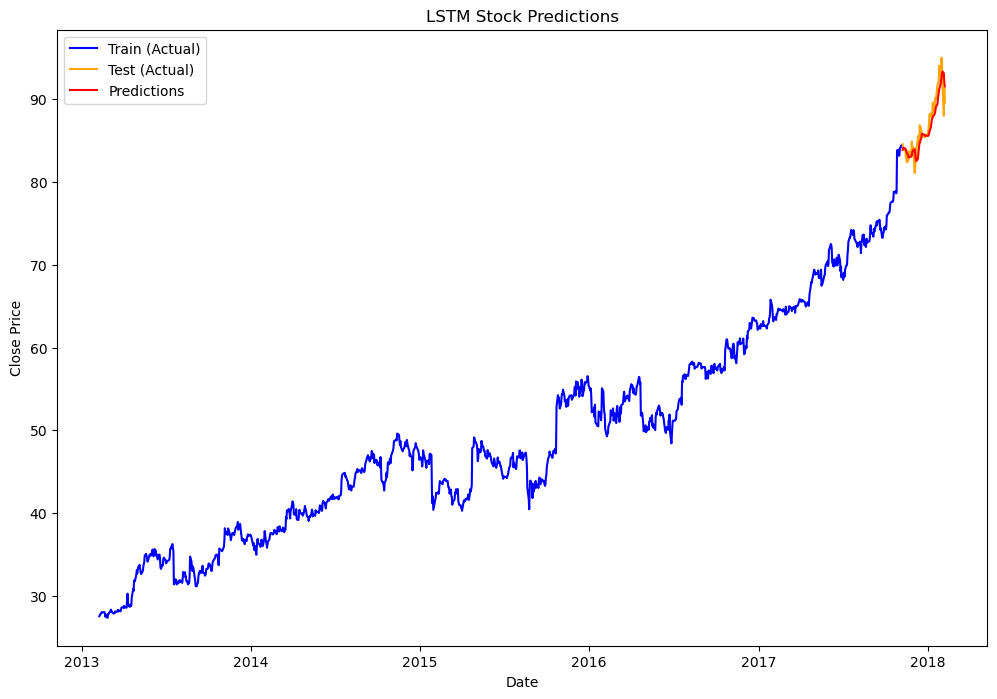

In [9]:
# Visualize actual vs. predicted stock prices
train = data[:training_data_len]
test = data[training_data_len:].copy()
test['Predictions'] = predictions

plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("LSTM Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [10]:
# Evaluate model performance on test set using MAE and RMSE
test_loss, test_rmse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

Test MAE: 84.3939, Test RMSE: 84.4597


In [11]:
# Naive baseline: yesterday's price is today's prediction
naive_preds = y_test[:-1]
actual = y_test[1:]

naive_mae = mean_absolute_error(actual, naive_preds)
print(f"Naive Baseline MAE: {naive_mae:.4f}")

Naive Baseline MAE: 0.8267


In [12]:
# Calculate R² score to assess how well predictions explain the variance in actual values
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

R² Score: 0.8337


In [13]:
# Measure and display model training time for benchmarking
start = time.time()
training = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
end = time.time()

print(f"Training time: {end - start:.2f} seconds")

Training time: 11.77 seconds


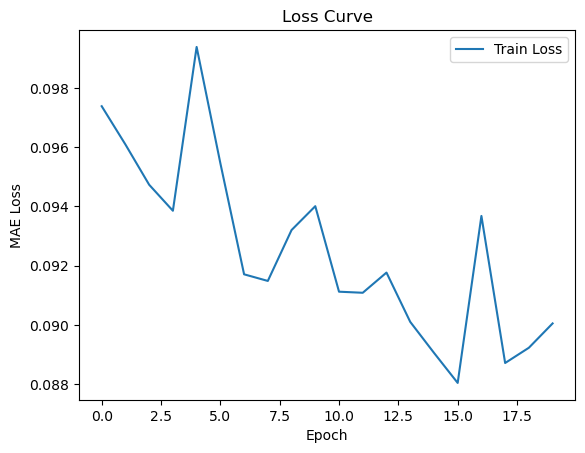

In [14]:
# Visualize training loss over epochs to evaluate model convergence
plt.plot(training.history['loss'], label='Train Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()